# Kaggle - TMDB 

### Extract tables - cast

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math

In [2]:
MILLION = 1000000

In [3]:
train = pd.read_csv('train.csv')

In [4]:
n_cast_counts = train['cast'].fillna('[{}]').map(lambda x: len(ast.literal_eval(x))).value_counts()

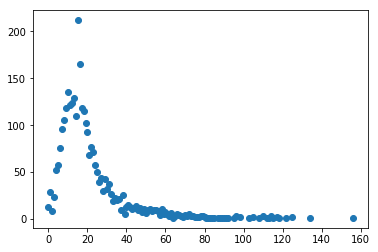

In [5]:
plt.scatter(n_cast_counts.index,n_cast_counts.values)

In [6]:
train['cast_expand'] = train['cast'].fillna('[{"id":-234,"name":"","cast_id":-234}]').map(lambda x: [(f['id'],f['name'],f['cast_id']) for f in ast.literal_eval(x)])

In [7]:
# get all ids, names and cast_ids
all_tuples = []
for i in train['cast_expand']:
    all_tuples.extend(i)
len(all_tuples)

61824

In [8]:
names = {}
for i in all_tuples:
    names[i[0]] = i[1]
len(names)

38761

In [9]:
len(set([i[2] for i in all_tuples]))

470

In [10]:
ast.literal_eval(train.iloc[2970]['cast'])[:3]

[{'cast_id': 17,
  'character': 'Rachel Marron',
  'credit_id': '52fe425fc3a36847f801916d',
  'gender': 1,
  'id': 8851,
  'name': 'Whitney Houston',
  'order': 0,
  'profile_path': '/69ouDnXnmklYPr4sMJXWKYz81AL.jpg'},
 {'cast_id': 18,
  'character': 'Frank Farmer',
  'credit_id': '52fe425fc3a36847f8019171',
  'gender': 2,
  'id': 1269,
  'name': 'Kevin Costner',
  'order': 1,
  'profile_path': '/ePo87kGyyY8JZ3z7Zm7Z2GYdmJ8.jpg'},
 {'cast_id': 19,
  'character': 'Nicki Marron',
  'credit_id': '52fe425fc3a36847f8019175',
  'gender': 0,
  'id': 8852,
  'name': 'Michele Lamar Richards',
  'order': 2,
  'profile_path': '/l06GC3nwCQiDFJ5kkEDy0dqJfkA.jpg'}]

In [11]:
# cast_id doesn't seem to be very clear, I need order instead

In [12]:
train['cast_expand'] = train['cast'].fillna('[{"id":-234,"name":"","order":-234}]').map(lambda x: [(f['id'],f['name'],f['order']) for f in ast.literal_eval(x)])

In [13]:
all_tuples = []
for i in train['cast_expand']:
    all_tuples.extend(i)
len(all_tuples)

61824

In [14]:
len(set([i[2] for i in all_tuples]))

157

In [15]:
actors = pd.Series(names).to_frame()
actors.columns = ['name']
actors.head()

,name
52997,Rob Corddry
64342,Craig Robinson
54729,Clark Duke
36801,Adam Scott
54812,Chevy Chase


In [16]:
# arbitrary choice
actors[actors['name'] == 'Bruce Willis']

,name
62,Bruce Willis


In [17]:
train[train['cast_expand'].map(lambda x: True if 62 in [i[0] for i in x] else False)]['title']

110                         Bandits
286                           Split
388                           Setup
434            The Astronaut Farmer
506              What Just Happened
739                        Sin City
900           The Cold Light of Day
969                 The Expendables
1018                         Looper
1180                 Precious Cargo
1182              The Fifth Element
1251             Look Who's Talking
1685                     The Jackal
1943            The Whole Ten Yards
1994              Last Man Standing
2033                      Alpha Dog
2182                     Hart's War
2233                        Cop Out
2273                     The Player
2356                    Hudson Hawk
2403    The Bonfire of the Vanities
2440            Lucky Number Slevin
2667           The Whole Nine Yards
2736                     Extraction
2773                      The Siege
Name: title, dtype: object

In [18]:
# Astronaut Farmer doesn't sound familiar
[x for x in train.iloc[434]['cast_expand'] if x[0]==62]

[(62, 'Bruce Willis', 59)]

order 59 is probably a very small role

In [19]:
def order_lower_than(ls,ind,order):
    # list is the tuple with id, name and order
    for i in ls:
        if (i[0] == ind):
            if (i[2]<order):
                return True
            else:
                return False
    # not found at all
    return False

In [20]:
train[train['cast_expand'].map(lambda x:order_lower_than(x,62,10))]['title']

110                         Bandits
388                           Setup
506              What Just Happened
739                        Sin City
900           The Cold Light of Day
1018                         Looper
1180                 Precious Cargo
1182              The Fifth Element
1251             Look Who's Talking
1685                     The Jackal
1943            The Whole Ten Yards
1994              Last Man Standing
2033                      Alpha Dog
2182                     Hart's War
2233                        Cop Out
2356                    Hudson Hawk
2403    The Bonfire of the Vanities
2440            Lucky Number Slevin
2667           The Whole Nine Yards
2736                     Extraction
2773                      The Siege
Name: title, dtype: object

**Try and find correlation between actor, revenue and order**

In [21]:
train[train['cast_expand'].map(lambda x: True if 62 in [i[0] for i in x] else False)]['revenue'].mean()/MILLION

83.66143352

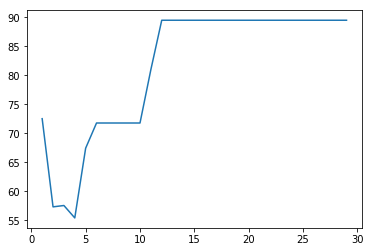

In [22]:
averages = []
mx = 30
for i in range(mx):
    ave = train[train['cast_expand'].map(lambda x:order_lower_than(x,62,i))]['revenue'].mean()/MILLION
    averages.append(ave)
plt.plot(range(mx),averages)
plt.show()

That is somewhat unexpected, check another famous actor

In [23]:
actors[actors['name'] == 'Dwayne Johnson']

,name
18918,Dwayne Johnson


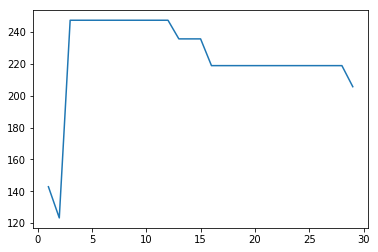

In [24]:
actor = 18918
averages = []
mx = 30
for i in range(mx):
    ave = train[train['cast_expand'].map(lambda x:order_lower_than(x,actor,i))]['revenue'].mean()/MILLION
    averages.append(ave)
plt.plot(range(mx),averages)
plt.show()

Somewhat more expected, but still the start of the curve is surprising

In [25]:
actors[actors['name'] == 'Samuel L. Jackson']

,name
2231,Samuel L. Jackson


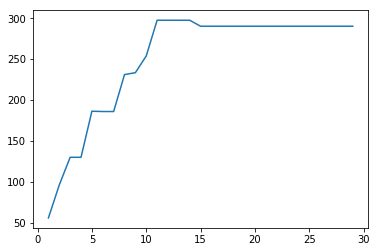

In [26]:
actor = 2231
averages = []
mx = 30
for i in range(mx):
    ave = train[train['cast_expand'].map(lambda x:order_lower_than(x,actor,i))]['revenue'].mean()/MILLION
    averages.append(ave)
plt.plot(range(mx),averages)
plt.show()

It appears that on average, the order feature is not very helpful to predict the revenues, per actor

**Perhaps this is an indication that successful movies are able to get high paid actors even in small roles?**

### Onwards

In [27]:
# get the number of movies for each actor

In [53]:
counts = []
for i in actors.index:
    counts.append(train['cast_expand'].map(lambda x:i in [j[0] for j in x]).sum())

In [56]:
actors['counts'] = counts

In [57]:
actors.head()

,name,counts
52997,Rob Corddry,5
64342,Craig Robinson,7
54729,Clark Duke,6
36801,Adam Scott,13
54812,Chevy Chase,8


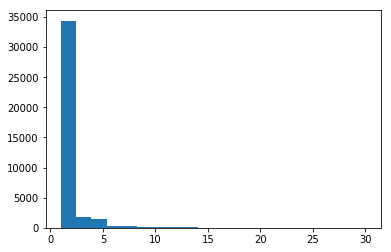

In [61]:
plt.hist(actors['counts'],bins=20)
plt.show()

In [69]:
actors['counts'].value_counts()

1     29493
2      4880
3      1787
4       859
5       525
6       333
7       222
9       145
8       142
10       81
12       54
11       51
13       45
14       36
15       28
16       19
17       14
19       11
18        8
20        8
21        6
25        4
22        3
23        2
24        2
30        2
27        1
Name: counts, dtype: int64

Find average revenue per actor (only for those with 5 movies or more)

In [85]:
revs = {}
for i in actors.index:
    if (actors.loc[i]['counts']>=5):
        revs[i] = (train['revenue'][train['cast_expand'].map(
            lambda x:i in [j[0] for j in x])].map(math.log).mean())

In [94]:
actors['revenue'] = actors.index.map(revs)
actors.head()

,name,counts,revenue
52997,Rob Corddry,5,17.301041
64342,Craig Robinson,7,16.783682
54729,Clark Duke,6,17.483381
36801,Adam Scott,13,16.460071
54812,Chevy Chase,8,17.201902


In [95]:
actors.to_csv('actors.csv')